In [1]:
import json
import pandas as pd

In [2]:
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 999)

In [3]:
%%time
from pymongo import MongoClient

MONGO_HOST= 'mongodb://localhost/twitterdata'
client = MongoClient(MONGO_HOST)
db = client.twitterdata
coll = db.abortolegal

tweets = []
users = {}
cols_tweet = ['id', 'created_at', 'favorite_count', 'retweet_count', 'full_text',
              'posicion', 'favorited', 'retweeted']
cols_user = [
             u'created_at',
             u'description',
             u'favourites_count',
             u'followers_count',
             u'friends_count',
             u'id',
             u'location',
             u'name',
             u'screen_name',
             u'statuses_count',
             u'verified']

for t in coll.find():
    tr = [t[c] for c in cols_tweet] + [t['user']['name'], t['user']['id']]
    tr.append(t['retweeted_status']['id'] if t['retweeted'] else t['id'])
    tweets.append(tr)
    uid = t['user']['id'] 
    if uid not in users:
        users[uid] = [t['user'][c] for c in cols_user]

CPU times: user 4min 42s, sys: 7.15 s, total: 4min 49s
Wall time: 5min 46s


In [4]:
%%time
tweets = pd.DataFrame(tweets, columns=cols_tweet + ['user_name', 'user_id', 'original_id'])
users = pd.DataFrame(users.values(), columns=cols_user)

CPU times: user 3.64 s, sys: 88.2 ms, total: 3.73 s
Wall time: 3.75 s


In [5]:
%%time
tweets['created_at'] = pd.to_datetime(tweets['created_at'],
                                      format="%a %b %d %H:%M:%S +0000 %Y")

CPU times: user 7.92 s, sys: 50.9 ms, total: 7.97 s
Wall time: 8.01 s


In [6]:
%%time
users['created_at'] = pd.to_datetime(users['created_at'],
                                      format="%a %b %d %H:%M:%S +0000 %Y")

CPU times: user 3.39 s, sys: 23.7 ms, total: 3.41 s
Wall time: 3.42 s


In [7]:
tweets_no = tweets[tweets.posicion == 'no']
len(tweets_no)

250768

In [8]:
tweets_si = tweets[tweets.posicion == 'si']
len(tweets_si)

732913

In [9]:
%%time
tweets.groupby([tweets.created_at.dt.date, tweets.posicion])['created_at'].count()

CPU times: user 2.77 s, sys: 96.7 ms, total: 2.86 s
Wall time: 2.83 s


created_at  posicion
2018-06-07  no          15342 
            si          22950 
2018-06-08  no          15771 
            si          30798 
2018-06-09  no          8073  
            si          31084 
2018-06-10  no          31808 
            si          50560 
2018-06-11  no          41941 
            si          59162 
2018-06-12  no          20952 
            si          107945
2018-06-13  no          62182 
            si          229154
2018-06-14  no          43596 
            si          136390
2018-06-15  no          11103 
            si          64870 
Name: created_at, dtype: int64

# Tweets más retuiteados

In [10]:
# esto es para que pandas muestre el texto completo
pd.set_option('display.max_colwidth', -1)
import re

### Sí

In [11]:
df = tweets_si[['retweet_count', 'full_text']]
# Removemos menciones en RTs
df.full_text = df.full_text.apply(lambda s: re.sub(r"^RT @\w+: ", "", s))
df = df.groupby('full_text').max()
df = df.sort_values(by='retweet_count', ascending=False).head(40)

### Para evitar duplicados, extendemos los tuits recortados

In [12]:
long_tweets = list(set(tweets[tweets.full_text.str.len() > 140].full_text.values))

len(long_tweets)

def extend_to_original(t):
    if len(t) > 140 or t[-1] != u'…':
        return t
    for l in long_tweets:
        if l.startswith(t[:-1]):
            return l
    return t

In [13]:
df['full_text'] = df.index
df.full_text = df.full_text.apply(extend_to_original)
df = df.groupby('full_text').max()
df.sort_values(by='retweet_count', ascending=False).head(20)

,retweet_count
full_text,
"Argentina, 1984.\nArgentina, 2018.\n\nDespués de 3 décadas, ¡por fin Argentina hace historia! La cámara de diputados vota a favor de la despenalización del aborto. \n💚💚💚💚💚💚💚💚\n\n#AbortoSeraLey https://t.co/gUyOq2r0Tw https://t.co/RvYwF4Aok5",43091
Se gritó como un gol de Messi. Emoción. #AbortoLegalYa https://t.co/mRQD3iKfW3,34568
Lo PERFECTO que habló Victoria Donda\n #QueSeaLey #AbortoLegalYa #AbortoSesionHistorica https://t.co/Fcy5XFj9SG,25102
"""estoy a favor de las 2 vidas, por eso es que voto a favor de la despenalización del aborto"" MIREN LA CARA DE LA DE ABAJ…",22886
"#AbortoLegalYa - sigan este hilo.\nNO SOY NEUTRAL.\nMi nombre es Cecilia Ousset. Soy católica, médica, especialista en tocoginecología, madre de cuatros hijos. Trabajo actualmente en el Sistema de Salud privado, aunque me formé y trabajé en el Sistema Público en la Ciudad de Mza.",14641
"Argentina tiene que avanzar! El aborto existió siempre!\nBasta de muertes en la clandestinidad!\nUn país con mejor educación sexual, y leyes que protejan a sus ciudadanos! \nNo retrocedamos! Avancemos! #AbortolegalYA #AbortoLegalOClandestino",14448
"En las calles, en lxs jóvenes, este debate ya está ganado💚\n#ElFuturoYallego #AbortoSeraLey https://t.co/PAj9oJ7lnY",11751
"Si no llegamos nosotras, lo van a conseguir ellas. \n#AbortoLegalYa https://t.co/JqjJPkvyAK",11329
Se entiende? #AbortoLegalYa https://t.co/c8UOiE51VV,9587


### No

In [14]:
df = tweets_no[['retweet_count', 'full_text']]
df.full_text = df.full_text.apply(lambda s: re.sub(r"^RT @\w+: ", "", s))
df = df.groupby('full_text').max()
df = df.sort_values(by='retweet_count', ascending=False).head(40)

In [15]:
df['full_text'] = df.index
df.full_text = df.full_text.apply(extend_to_original)
df = df.groupby('full_text').max()
df.sort_values(by='retweet_count', ascending=False).head(20)

,retweet_count
full_text,
"#NoAlAborto En el aborto ""Seguro"", seguro alguien muere, ""Gratuito"" alguien lo paga y muy caro, ""Libre"" alguien no eligió, ""Leg…",5039
"APLAUSOS DE PIE para éstos médicos tucumanos que grabaron éste spot contra el ABORTO.\n\n""Estudiamos para cuidar la vida de todos. Si estás pensando en nosotros para practicar abortos, NO CUENTEN CONMIGO"" 👏👏👏\n\nRT que lo vean todos 🇦🇷\n\n#SalvemosLas2Vidas\n#NoAlAborto #SiAlavida https://t.co/Vwd4etkRvt",2743
"Venimos de un país donde CFK perseguía y hostigaba a todo aquel que hablase mal de ella.\n\nMACRI, en cambio, invitó a los COCINEROS ARGENTINOS a Olivos, luego que ellos le cantaran MMLPQTP. #Cambiamos\n\n#PorElMundo #ArgentinaEsProvida https://t.co/p7d5z4T9Tm",2459
"Venimos de un país donde CFK perseguía y hostigaba a todo aquel que hablase mal de ella.\n\nMACRI, en cambio, invitó a los COCINEROS ARGENTINOS a Olivos, luego que ellos le cantaran MMLPQTP. #Cambiamos\n\nHoy salió el programa grabado. Pasen y vean👇 \n\n#PorElMundo #ArgentinaEsProvida https://t.co/2MU5yGA1oY",2458
"¿Saben qué es lo mejor de los pro-vida? Que somos mayoría en Argentina sin recibir los millones de dólares que los abortistas han recibido de internacionales de la muerte, como Planned Parenthood, para llevar adelante su campaña mortífera.\n#ArgentinaEsProvida",2194
Con Uma decimos: SI A LA VIDA #CuidemosLasDosVidas ❤️❤️ https://t.co/mGfDwWIIWO,2009
"Hasta el momento estos son los números: 127 diputados a favor de la vida, 123 a favor del genocidio, y todavía algunos que no se deciden entre la vida y el genocidio.\n#AbortoSesiónHistórica #SalvemosLas2Vidas \n\nAgustín Laje \n\nSigamos rezando por los diputados",1976
"Hasta el momento estos son los números: 127 diputados a favor de la vida, 123 a favor del genocidio, y todavía algunos que no se deciden entre la vida y el genocidio.\n#AbortoSesiónHistórica #SalvemosLas2Vidas",1969
"TOMA DE COLEGIOS: Una causa justa por un pañuelo, $100 y una vianda.\n\n-J: ""Nos dan los pañuelos gratis, $ 100 y una vianda para la noche"" \n- P: Quienes se los dan?\n- J: ""No puedo decirte""\n- P: Ok, entiendo\n\n#QueElAbortoSeaLey\n\n#SalvemosLas2Vidas \n\n#ArgentinaEsProvida https://t.co/sJq5QAKcOe",1961


## Análisis usuari@s

In [16]:
len(users)

314504

In [17]:
users_si = users[users.id.isin(tweets_si.user_id)]
len(users_si)

265931

In [18]:
users_no = users[users.id.isin(tweets_no.user_id)]
len(users_no)

67171

## más activ@s

## Sí

In [19]:
top = tweets_si.user_id.value_counts()[:30]
top_users = users[users.id.isin(top.index)]
top_users['n_tweets'] = top_users.id.apply(lambda i: top[i])
top_users.sort_values(by='n_tweets', ascending=False)

,created_at,description,favourites_count,followers_count,friends_count,id,location,name,screen_name,statuses_count,verified,n_tweets
259844,2010-09-24 02:29:14,No soy lo que hago. Soy infinita ✌️✌️✌️ Nac & Pop,87699,1310,2171,194421006,"Bragado, Argentina",María Laura P,mlaurapratt,79435,False,669
187472,2011-07-11 06:26:51,Carnivora --- Endemoniada,7458,1145,1304,333236636,,Gabriela Martinez,gabrielamartf,218414,False,659
180839,2010-06-20 07:36:50,Feminista Médico Psiquiatra Psicodramatista DDHH Peronista Profundamente irrespetuoso con cualquier conducta dominante & gurúes & líderes religiosos,14932,6957,6923,157589057,"Buenos Aires, Argentina",Enrique Stola,Stolae,66582,False,614
263187,2013-07-30 10:19:47,.,3609,75,364,1632548502,Ushuaia. Argentina,Lucia Trebucq,luciatre86,2747,False,548
109873,2015-01-03 17:24:49,,7713,88,1001,2958741387,,el paraiso,macia753,3765,False,481
156383,2017-12-03 01:48:36,Orgullosa docente en formación del Instituto Dr Joaquín V. González,12643,287,231,937136453313859584,Argentina,JulietaISPJVG,Julieta75672001,19835,False,458
226871,2013-09-15 14:23:55,Médica especializada en Salud Pública (UBA). Diputada Nacional (M.C). Vivo en #Beccar.,53240,13514,1188,1867893876,San Isidro,Marcela Durrieu,MarcelaDurrieu,130388,True,424
268383,2011-05-22 23:33:02,,70158,820,2001,303487087,"Buenos Aires, Argentina.",Marcia Gomez,marciaegomez,79378,False,413
120977,2018-02-25 19:18:35,,2272,1905,239,967841272659628039,"Ciudad Autónoma de Buenos Aires, Argentina",Activa el Congreso,activacongreso,2124,False,295
100970,2010-02-11 17:51:02,Feminist. Pro-choice. Atheist. Pan.\nWhovian. Jrocker. Manga & J-Fashion lover. Bookworm. Potterhead. Nerd. Fujoshi. Awkward.,4083,95,195,113415672,Argentina,Xiomara B.,Chibixio,1300,False,294


## No

In [20]:
top = tweets_no.user_id.value_counts()[:30]
top_users = users[users.id.isin(top.index)]
top_users['n_tweets'] = top_users.id.apply(lambda i: top[i])
top_users.sort_values(by='n_tweets', ascending=False)

,created_at,description,favourites_count,followers_count,friends_count,id,location,name,screen_name,statuses_count,verified,n_tweets
5051,2018-05-23 00:49:48,Provida,2210,127,668,999089982227742721,Argentina,Gerardo Williams,FfErnest,2013,False,649
112773,2016-04-27 01:23:44,,6086,108,566,725133295583907840,,ÁngelesEsperAspiazú,AspiazuEsper,1854,False,630
41034,2014-05-16 10:46:04,,9120,101,108,2498301943,,SilvanaA,patubela001,7964,False,476
223750,2010-10-24 03:37:35,"""Oye, Israel: el Señor nuestro Dios, el Señor uno es."" 🕎🇮🇱✝❤",3544,649,534,206944231,Kingdom Of Heavens,Isabella Gómez,IsaBellaNHoran,7837,False,432
27912,2009-06-10 18:23:30,https://t.co/TZhKGH7f3b|503🇸🇻|al ALIANZA FC lo amo con locura💙🐘42.|Invictus😍|River♥️🐔|acting student🎬🇮🇳|Pokémon💛|,19094,3902,1948,46184752,CABA🇦🇷,Carmen Elena Pinto🏆🐘,CarmenElenaAFC,120407,False,407
132837,2012-03-12 02:40:13,"En la izquierda hay oportunistas, en la derecha canibalismo, el camino es la Doctrina Social de la Iglesia. Viva Cristo Rey!!! Provida",4130,827,830,521888649,Ecuador,J Andino,johnnyandino1,162300,False,395
122159,2017-10-18 02:05:50,,3367,13,347,920470947987099648,,Julucata,Julucata2,1321,False,392
292974,2018-04-17 04:31:28,Bancando a la reina @micaviciconte futbol /volley \n\n#MTVLAINSTAARVICICONTE \n#PremiosMTVMiaw,99,45,212,986099802168549381,"Tucumán, Argentina",lucas micaelisto,lucasmicaelist6,6129,False,372
34824,2015-10-23 23:41:11,"Por eso, si me querés hablar de amor... vení que te cuento qué es ser de CARAHUE🖤",4150,160,198,4027639589,,Marti💙,martigonzalez02,3736,False,368
30847,2012-02-21 21:13:04,"Silchis, Sil o La Morocha\r\nDe la Pcia de SnJn Arg\nPresidenta de @EclipseFco 🌘\nFans Club Oficial de @LucianoPereyra 💗\nDesde el 14/02/2000\nY vamos por más!!! 💪",18575,448,932,499174600,San Juan,Silvia Pereira,Silchis_ok,31774,False,361


## Actividad

In [21]:
users_si.statuses_count.describe()

count    2.659310e+05
mean     1.688819e+04
std      2.922364e+04
min      1.000000e+00
25%      1.905000e+03
50%      7.417000e+03
75%      2.040850e+04
max      1.178440e+06
Name: statuses_count, dtype: float64

In [22]:
users_no.statuses_count.describe()

count    6.717100e+04
mean     1.572302e+04
std      3.316994e+04
min      1.000000e+00
25%      1.063000e+03
50%      5.065000e+03
75%      1.683700e+04
max      1.078813e+06
Name: statuses_count, dtype: float64

## Seguidores

In [23]:
users_si.followers_count.describe()

count    2.659310e+05
mean     1.670350e+03
std      4.027103e+04
min      0.000000e+00
25%      1.310000e+02
50%      3.480000e+02
75%      7.780000e+02
max      1.026598e+07
Name: followers_count, dtype: float64

In [24]:
users_no.followers_count.describe()

count    6.717100e+04
mean     1.117621e+03
std      1.812344e+04
min      0.000000e+00
25%      8.100000e+01
50%      2.600000e+02
75%      6.780000e+02
max      3.039071e+06
Name: followers_count, dtype: float64

## Fechas de creación de perfiles

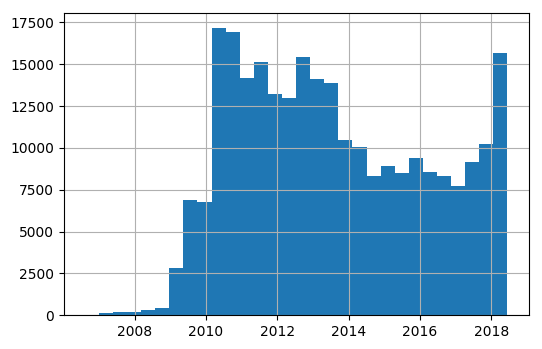

In [25]:
users_si.created_at.hist(bins=30)

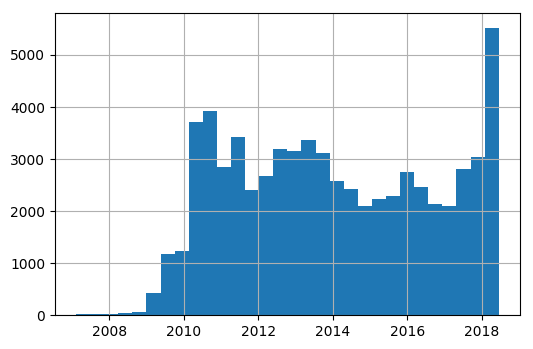

In [26]:
users_no.created_at.hist(bins=30)

## Cuentas verificadas

In [27]:
users_si.verified.value_counts()

False    265257
True     674   
Name: verified, dtype: int64

In [28]:
users_no.verified.value_counts()

False    67099
True     72   
Name: verified, dtype: int64

In [29]:
users_si[users_si.verified]

,created_at,description,favourites_count,followers_count,friends_count,id,location,name,screen_name,statuses_count,verified
554,2015-08-30 22:48:44,Con los ojos atentos y las palabras a mano. Secretaria de Feminismos Interseccional y LGTBI en @ahorapodemos. Diputada por Asturies en el Congreso.,10519,11693,1941,3495603017,"Xixón, Asturies",Sofía Castañón,SofCastanon,10173,True
3049,2010-06-16 11:45:01,El Trece - Radio Conexion Abierta,64723,383665,2528,156242969,Argentina,Luis Bremer,luisbremer,272602,True
3061,2010-08-01 19:29:48,Socióloga e investigadora. Activista del Nuevo Perú. Congresista de la República del Perú.,2490,249071,599,173544494,Peru,Marisa Glave,MarisaGlave,11125,True
3915,2011-02-25 12:05:58,Dirigente nacional del @PartidoObrero en el Frente de Izquierda,175,41003,506,257432060,Ciudad de Buenos Aires,Néstor Pitrola,nestorpitrola,31348,True
4189,2011-02-06 16:02:52,CONTRATACIONES e INFORMACION: Info@marianoberonmusic.com\nhttps://t.co/v2zpGtgV1G\n https://t.co/cyy6NwBUqV https://t.co/zifPcG4Lvc,31902,98604,293,248251555,Buenos Aires,Mariano Beron 🤪,Marianoberonok,7285,True
4347,2010-06-22 11:48:26,Secretario Gral. de @ahorapodemos y diputado en el Congreso. Profesor honorífico de la UCM. Nadie duda de que este país ya ha cambiado. ¡Sí se puede!,6526,2308222,2641,158342368,Madrid,Pablo Iglesias,Pablo_Iglesias_,18838,True
4985,2010-08-05 19:51:59,Médico. Ex Gobernador de la Provincia de Santa Fe,320,177786,191,175157212,Santa Fe - Argentina,Hermes Binner,HermesBinner,2994,True
4994,2014-08-07 15:13:07,"Diputado del Parlasur. Ex Canciller de la Nación. Peronista. Sociólogo, Director del CIEP (UNSaM). Casado. Padre de tres hijxs.",1352,67952,558,2714771804,"Buenos Aires, Argentina",Jorge Taiana,JorgeTaiana,7228,True
5235,2010-05-17 03:21:22,1 0 3 0 #LAM,16403,3039071,18,144712423,,🅰️NGELITO,AngeldebritoOk,262357,True
5311,2008-08-05 15:57:57,Productor Musical - DJ - Conductor de #MinutosContados - Radio De Plata,23377,318262,5455,15737712,,camilogarcia,camilogarcia,34843,True


In [30]:
users_no[users_no.verified]

,created_at,description,favourites_count,followers_count,friends_count,id,location,name,screen_name,statuses_count,verified
1507,2008-12-03 04:06:54,Cuenta Oficial de ACI Prensa | Noticias y recursos sobre la Iglesia Católica en todo el mundo.,1462,262695,970,17828368,,ACI Prensa,aciprensa,74215,True
4130,2012-02-02 00:36:50,No respondo mensajes privados.,30886,289880,32188,480860644,,Viviana,vivicanosaok,19649,True
5235,2010-05-17 03:21:22,1 0 3 0 #LAM,16403,3039071,18,144712423,,🅰️NGELITO,AngeldebritoOk,262357,True
5461,2009-11-25 10:20:39,Asociación de asociaciones que trabajan por la Familia. #HablandoBienDeLasCosasBuenas,2617,12084,412,92492730,Españab,Foro de la Familia,ForoFamilia,12759,True
8291,2009-09-01 21:35:55,Conductora de deportes en @adrenalina e @ImagenTVDeporte Contrataciones: PauGomezcaro@gmail.com,17046,14618,1010,70792916,,Pau Gomezcaro,PauGomezcaro,25370,True
16369,2015-11-16 00:55:37,"Presidente del Bloque PRO, Honorable Cámara de Diputados de la Nación",94,35876,142,4198001913,,Nicolás Massot,Nicolas_Massot,676,True
24316,2008-09-15 11:08:46,"Noticias desde Buenos Aires, Argentina. Periodismo puro en tiempo real.",276,738338,2207,16294264,Argentina,Perfil.com,perfilcom,170254,True
24502,2010-06-29 18:14:55,"Argentina, politóloga, madre de 3 hijos maravillosos y Secretaria de Infraestructura Urbana de la Nación.",3330,22908,846,160998065,Ciudad Autónoma de Buenos Aire,Marina Klemensiewicz,Klemensiewicz,5189,True
29873,2010-10-09 01:04:54,Cuenta Oficial de la Periodista de Espectaculos en @telefenoticias @buentelefe Corresponsal argentina de HOLATV para Miami y Latinoamerica. Canal 26/Late93.1,15712,257314,3308,200328797,argentina,Pilar Smith,Pilarsmith,44597,True
30333,2012-07-17 12:35:08,Todo Jujuy Diario digital. Noticias al instante las 24 hs.,562,15914,255,700978591,San Salvador de Jujuy,Todo Jujuy,diarioTodoJujuy,65031,True
